In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)

import xgboost as xgb

df = pd.read_excel("c:/Users/HP/Documents/Infosysspring/futurepreprocessed_dataset.xlsx")
df.head()


,order_id,supplier_id,supplier_rating,supplier_lead_time,order_date,promised_delivery_date,actual_delivery_date,shipping_distance_km,order_quantity,unit_price,...,region_South,region_West,holiday_period_Yes,carrier_name_DHL,carrier_name_Delhivery,carrier_name_EcomExpress,carrier_name_FedEx,delayed_reason_code_Operational,delayed_reason_code_Traffic,delayed_reason_code_Weather
0,0.0000,0.480276,0.36,1.000,2024-05-15,2024-05-25,2024-05-29,0.027517,0.474747,0.419177,...,False,False,False,False,False,True,False,True,False,False
1,0.0001,0.325814,0.72,1.000,2024-11-12,2024-11-22,2024-11-27,0.243624,0.909091,0.062228,...,False,False,True,True,False,False,False,False,False,False
2,0.0002,0.885209,0.28,0.375,2024-08-28,2024-09-02,2024-09-02,0.868456,0.242424,0.641179,...,True,False,False,False,False,False,False,True,False,False
3,0.0003,0.981442,0.56,0.625,2024-08-12,2024-08-19,2024-08-19,0.556376,0.707071,0.054150,...,False,False,False,False,False,False,True,True,False,False
4,0.0004,0.125125,0.28,0.750,2024-07-07,2024-07-15,2024-07-18,0.166443,0.080808,0.602684,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# feature target separation
X = df.drop(columns=["delivery_delay_days"])
y = df["delivery_delay_days"]


In [ ]:
# datatype validation
X = X.select_dtypes(include=["number", "bool"])
print("Final feature dtypes:")
print(X.dtypes.value_counts())


Final feature dtypes:
bool       17
float64    10
int64       1
Name: count, dtype: int64


In [ ]:
# Convert continuous target to binary classification
y = (df["delivery_delay_days"] > 0).astype(int)
print(y.value_counts())


delivery_delay_days
1    8647
0    1353
Name: count, dtype: int64


In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (8000, 28)
Testing size: (2000, 28)


In [ ]:
# models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(
       eval_metric="logloss",
    random_state=42

    )
}


In [ ]:
# Hyperparameter grid
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1]
    },
    "Random Forest": {
        "n_estimators": [100, 200],
        "max_depth": [None, 10]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 6],
        "learning_rate": [0.05, 0.1]
    }
}


In [ ]:
# Model training,HP tuning 
results = []
best_models = {}

for name, model in models.items():
    print(f"\nTraining {name}")
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=3,
        scoring="roc_auc",
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
results_df



Training Logistic Regression

Training Random Forest

Training XGBoost


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.8645,0.864500,1.000000,0.927326,0.915040
1,Random Forest,0.8620,0.871992,0.984962,0.925041,0.917554
2,XGBoost,0.8680,0.916904,0.931752,0.924269,0.923924


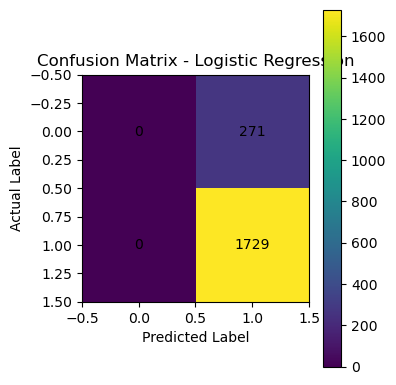

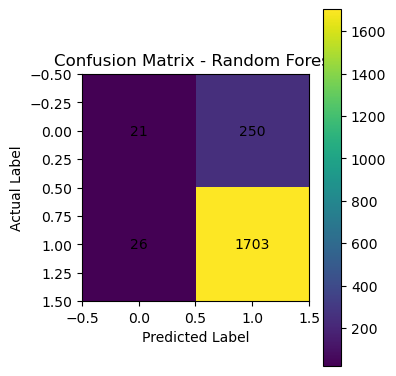

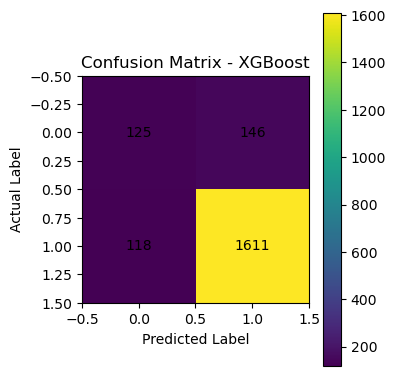

In [ ]:
# confusion matrix
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()

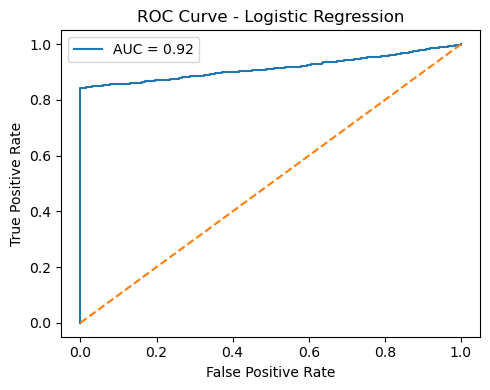

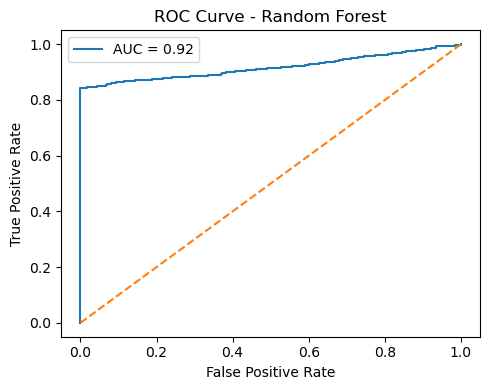

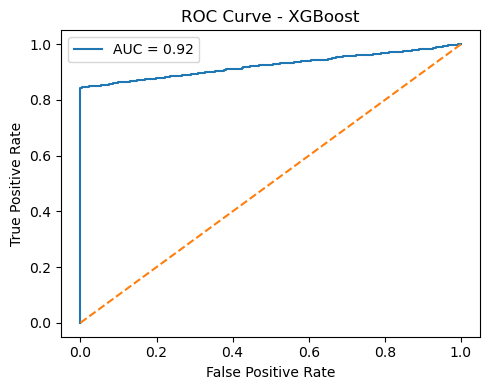

In [ ]:
# ROC curve
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


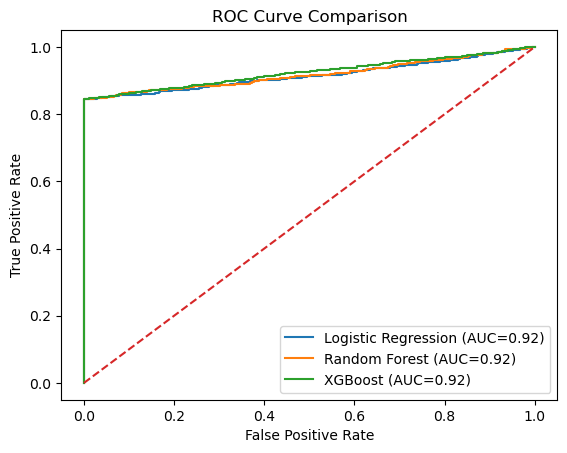

In [ ]:
# ROC curve comparison
plt.figure()

for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
# Final model
results_df["score"] = results_df["Accuracy"] + results_df["F1-Score"]
best_model = results_df.sort_values(by="score", ascending=False).iloc[0]
best_model


Model         XGBoost
Accuracy        0.868
Precision    0.916904
Recall       0.931752
F1-Score     0.924269
ROC-AUC      0.923924
score        1.792269
Name: 2, dtype: object